# INTRODUCCION AL ALGORITMO PROPHET

La libreria de Prophet  permite pronosticar datos de series de tiempo basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de los días festivos. Funciona mejor con series de tiempo que tienen marcados efectos estacionales y varias temporadas de datos históricos. Prophet es robusto ante los datos faltantes y los cambios de tendencia, y normalmente maneja bien los valores atípicos.

Para modelar la serie temporal Prophet, separamos la señal en los siguientes componentes aditivos:

y(t)= g(t) + s(t) + h(t) + εt

Dónde:


y(t) es la variable a pronosticar

g(t) es la función de tendencia que modela cambios no periódicos usando un modelo de crecimiento de saturación no lineal o un modelo de regresión lineal por partes. Puede configurar esto usando parámetros.

s(t) es el funcional estacional (anual, semanal y diario) que modela los cambios periódicos en el valor de la serie temporal. Este componente se modela mediante una transformada de Fourier y, si lo desea, puede agregar sus propias estacionalidades.

h(t) representa la función para modelar días festivos y eventos de impacto especial. Puede agregar su propio conjunto de feriados personalizados y eventos especiales.

εt es el error/ruido de los modelos que se supone que tiene una distribución 

Para un descripción mas detallade del algoritmo ir al Paper Prophet- https://peerj.com/preprints/3190/


# Hablar de los datos (como se construyeron las base de datos y de donde se descargaron) 

Importamos las libreriras para visualización, preprocesamiento y modelado de la serie de tiempo 

In [ ]:
#Instala Prophet
#!pip install fbprophet

In [ ]:
#Carga el paquete para modelar series de tiempo
from fbprophet import Prophet
import fbprophet
fbprophet.__version__


'0.7.1'

In [ ]:
#Carga paquetes generales
import numpy as np
import pandas as pd
from datetime import datetime
import itertools

# visual libraries
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.express as px
import os
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')
from seaborn import kdeplot





# modelado
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.serialize import model_to_json, model_from_json
from fbprophet.plot import plot_cross_validation_metric


# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# distribution of anomalous features
from sklearn.preprocessing import StandardScaler

# manejo de archivos
import json


# pruebas estadisticas de estacionalidad y causalidad
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#mpl.rcParams['figure.figsize'] = (10, 8)
#mpl.rcParams['axes.grid'] = False


In [ ]:
#Carga Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Define la ruta raiz del proyecto
ruta="/content/drive/MyDrive/AIre/BD/"

cargamos los datos de la estación a modelar le damos el formato de fecha, agregamos la fecha como indice y eliminamos las columnas que no son útiles.  

In [ ]:
#Carga datos de una estación
estac='MER'
df=pd.read_csv(ruta + estac +'2_2015_2020.csv')
df.date2=pd.to_datetime(df['date2'],format="%Y-%m-%d %H:%M:%S")
df=df.set_index('date2')
df.drop(columns=['WDR'],inplace=True,axis=1)      #en este modelo no se va a analizar WDR, para incluirla se requiere hacer la conversión de WSP-WDR a X-Y (de coordenadas polares a cartesianas)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41107 entries, 2015-01-01 00:00:00 to 2019-09-30 00:00:00
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        41107 non-null  object 
 1   Date        41107 non-null  object 
 2   Hour        41107 non-null  int64  
 3   year        41107 non-null  int64  
 4   id_station  41107 non-null  object 
 5   CO          35929 non-null  float64
 6   NO          36387 non-null  float64
 7   NO2         36387 non-null  float64
 8   NOX         36387 non-null  float64
 9   O3          38239 non-null  float64
 10  PA          36465 non-null  float64
 11  PBa         8491 non-null   float64
 12  PM10        34288 non-null  float64
 13  PM2.5       34288 non-null  float64
 14  PMCO        34288 non-null  float64
 15  RH          39759 non-null  float64
 16  SO2         37428 non-null  float64
 17  TMP         37702 non-null  float64
 18  WSP         38729 non-null  flo

In [ ]:
#Un vistazo al inicio de la base de datos
df.head(2)

date        Date  Hour  ...   TMP  WSP  Month
date2                                                    ...                  
2015-01-01 00:00:00  01/01/2015 01:00  01/01/2015     0  ...  11.9  1.3      1
2015-01-01 01:00:00  01/01/2015 02:00  01/01/2015     1  ...  10.7  0.9      1

[2 rows x 20 columns]

In [ ]:
#Un vistazo al final de la base de datos
df.tail(2)

date        Date  Hour  ...   TMP  WSP  Month
date2                                                    ...                  
2019-09-29 23:00:00  29/09/2019 24:00  29/09/2019    23  ...  15.5  3.2      9
2019-09-30 00:00:00  30/09/2019 01:00  30/09/2019     0  ...  14.7  3.4      9

[2 rows x 20 columns]

Determinamos el total de faltantes por cada columna del dataframe

In [ ]:
#Total de datos faltantes por variable (registros horarios)
df.isnull().sum()

date              0
Date              0
Hour              0
year              0
id_station        0
CO             5178
NO             4720
NO2            4720
NOX            4720
O3             2868
PA             4642
PBa           32616
PM10           6819
PM2.5          6819
PMCO           6819
RH             1348
SO2            3679
TMP            3405
WSP            2378
Month             0
dtype: int64

In [ ]:
#Función para realizar una gráfica interactiva del comportamiento de una variable
def graf_iter(df,fecha,var,est,reg="H"):
  df=df.reset_index()
  if reg=="H":
    prom="horaria"
  else:
    prom="diaria"

  fig = px.line(df, x=fecha, y=var, title='Concentración '+ prom +' de ' + var +' en ' + est)

  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(count=2, label="3y", step="year", stepmode="backward"),
              dict(count=3, label="5y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  fig.show()

Visualizamos el comportamiento de la variable a pronosticar, PM2.5 (registros horarios)

In [ ]:
#Un vistazo al comportamiento de la variables a pronosticar, PM2.5 (registros horarios)
graf_iter(df,'date2','PM2.5',estac)

Se puede apreciar los espacios en blanco correspondiente a los valores faltantes de PM2.5 en la estación MER. Hacemos las graficas de las series para los restantes variables de nuestro conjunto de datos-

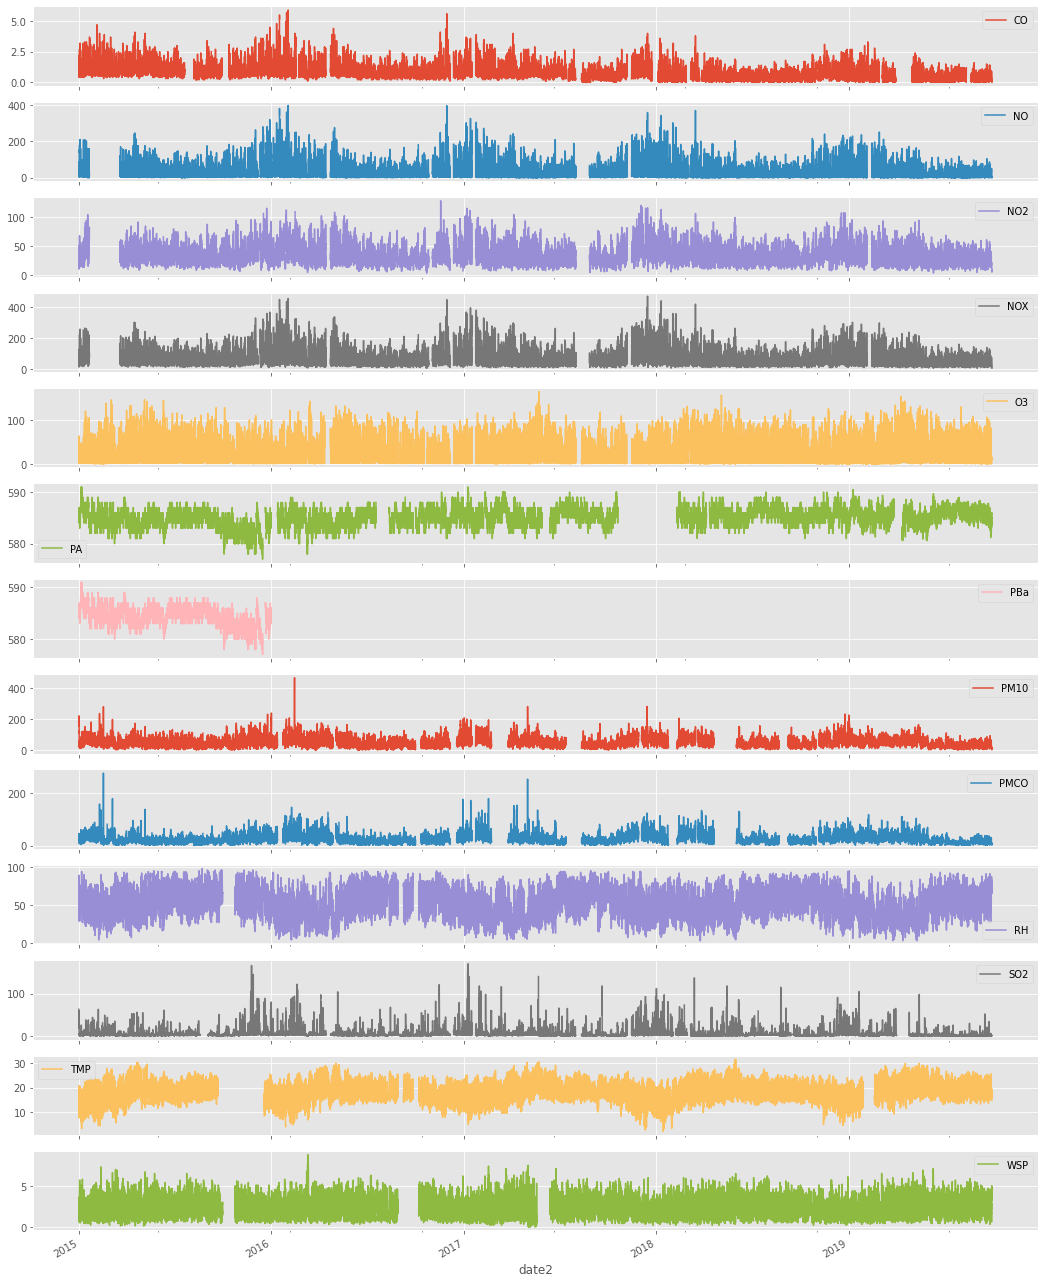

In [ ]:
#visualización registros horarios de las covaribles o variables regresoras
df[df.columns[~df.columns.isin(['date','Date','Hour','year','id_station','PM2.5','Month'])]].plot(subplots=True, figsize=(18,25))
plt.show()

Se puede apreciar el mismo patrón de faltantes para la series de los óxidos de nitrógenos y el CO. De igual forma se puede observa el mismo patrón de valores faltantes en la series de material particulado, esto es posible asociarlo a los períodos de mantenimiento de las estaciones de medición o posibles fallas.
La presión barométrica tenemos datos solo para el año 2015. 

Calculamos el promedio diario para todas las variables y eliminamos las que tiene mas de 50% de valores faltantes

In [ ]:
#Promedio diario
df_d=df[df.columns[~df.columns.isin(['date','Date','Hour','year','id_station','Month'])]].resample('D').mean()

#elimina las variables que no cuentan con al menos el 50% de datos diarios en el periodo
df_d=df_d[df_d.columns[df_d.count()>df_d.shape[0]*0.5]]
df_d

CO         NO        NO2  ...        SO2        TMP       WSP
date2                                       ...                                
2015-01-01  1.252174  36.956522  32.217391  ...  19.043478  13.804167  1.791667
2015-01-02  1.395833  64.083333  33.166667  ...   3.041667  13.862500  2.504167
2015-01-03  1.091304  40.608696  32.521739  ...   2.043478  14.608333  1.725000
2015-01-04  1.213636  46.772727  32.090909  ...   2.318182  12.891667  2.395833
2015-01-05  1.091667  30.458333  33.375000  ...   8.750000   8.500000  3.516667
...              ...        ...        ...  ...        ...        ...       ...
2019-09-26  0.516667  16.250000  30.541667  ...   1.541667  19.120833  2.225000
2019-09-27  0.316667  10.739130  25.304348  ...   1.173913  19.487500  2.475000
2019-09-28  0.442857  12.809524  26.714286  ...   2.333333  19.233333  2.437500
2019-09-29  0.295833  10.250000  14.083333  ...   1.166667  17.012500  2.945833
2019-09-30  0.000000   0.000000   5.000000  ...   1.000000  14.700000  3.400000

[1734 rows x 13 columns]

Determinamos el número de valores faltantes diarios por cada variable

In [ ]:
#Faltantes diarios
df_d.isnull().sum()

CO       172
NO       146
NO2      146
NOX      146
O3        66
PA       199
PM10     223
PM2.5    223
PMCO     223
RH        61
SO2      104
TMP      148
WSP      107
dtype: int64

Visualizamos el comportamineto de la variable PM2.5 diaria

In [ ]:
#Un vistazo al comportamiento de la variables a pronosticar, PM2.5 (registros diarios)
#se detectan algunos datos extremos
graf_iter(df_d,'date2','PM2.5',estac,"D")

Se puede apreciar en la grafica valores extremos para la concentración de PM2.5 diaria. Para el 1 de enero de 2016 se registra una concentración de aproximadamente 92 microgramos/cm3, para el 14 de febrero de 2016 de 96 microgramos/cm3 y el 25 de diciembre de 2018 de 93 microgramos/cm3.

Visualizamos el comportamiento de las restantes varianles de nuestro dataframe.

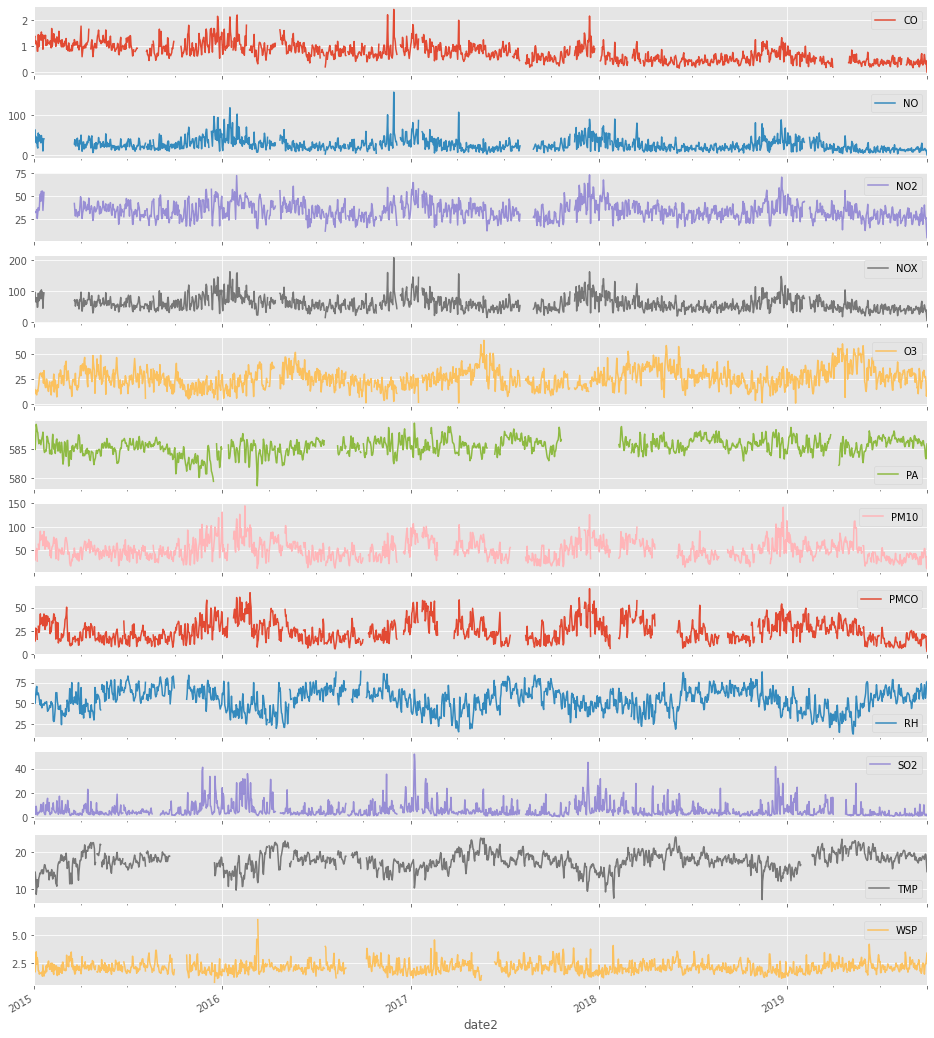

In [ ]:
#visualización registros diarios de las covaribles o variables regresoras
df_d[df_d.columns[~df_d.columns.isin(['PM2.5'])]].plot(subplots=True, figsize=(16,20))
plt.show()

Se puede apreciar menor variabilidad en los datos al calcular el promedio diario.



https://futurice.com/blog/business-forecasting-with-facebook-prophet

In [ ]:
#reordena la base de datos para tener la variable de interés al incio
orden=df_d.columns
x=pd.DataFrame(df_d[['PM2.5']])
y=pd.DataFrame(df_d[orden[~orden.isin(['PM2.5'])]])
df_d=pd.concat([x,y],axis=1)
print(df_d.shape)
print(df_d.head(2))
print(df_d.tail(2))
del x
del y

(1734, 13)
                PM2.5        CO         NO  ...        SO2        TMP       WSP
date2                                       ...                                
2015-01-01  69.000000  1.252174  36.956522  ...  19.043478  13.804167  1.791667
2015-01-02  20.217391  1.395833  64.083333  ...   3.041667  13.862500  2.504167

[2 rows x 13 columns]
               PM2.5        CO     NO  ...       SO2      TMP       WSP
date2                                  ...                             
2019-09-29  5.695652  0.295833  10.25  ...  1.166667  17.0125  2.945833
2019-09-30  9.000000  0.000000   0.00  ...  1.000000  14.7000  3.400000

[2 rows x 13 columns]


In [ ]:
#parametros a usar en la modelación
param=df_d.columns
param

Index(['PM2.5', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PA', 'PM10', 'PMCO', 'RH',
       'SO2', 'TMP', 'WSP'],
      dtype='object')

In [ ]:
#tranformación de y
# Apply Box-Cox Transform and save the lambda for later inverse.
# df_d['PM2.5'], lam = boxcox(df_d['PM2.5'])
# print('Lambda is:', lam)
#lognormal
df_d['PM2.5']=np.log(df_d['PM2.5'])
df_d['PM2.5']


date2
2015-01-01    4.234107
2015-01-02    3.006543
2015-01-03    2.719578
2015-01-04    3.034552
2015-01-05    2.775190
                ...   
2019-09-26    3.497824
2019-09-27    2.830653
2019-09-28    2.888054
2019-09-29    1.739703
2019-09-30    2.197225
Freq: D, Name: PM2.5, Length: 1734, dtype: float64

In [ ]:
#Un vistazo al comportamiento de la variables tranformada
#se confirman los datos extremos los cuales se dejan debido a que están asociados a días festivos repetitivos
#se eliminan: 25/12/2015, 1/01/2016, 14/02/2016, 25/12/2018, 1/01/2019, 12/05/2019, 13/05/2019
graf_iter(df_d,'date2','PM2.5',estac+" (transformada logaritmo)","D")


Densidad de datos horarios de PM2.5


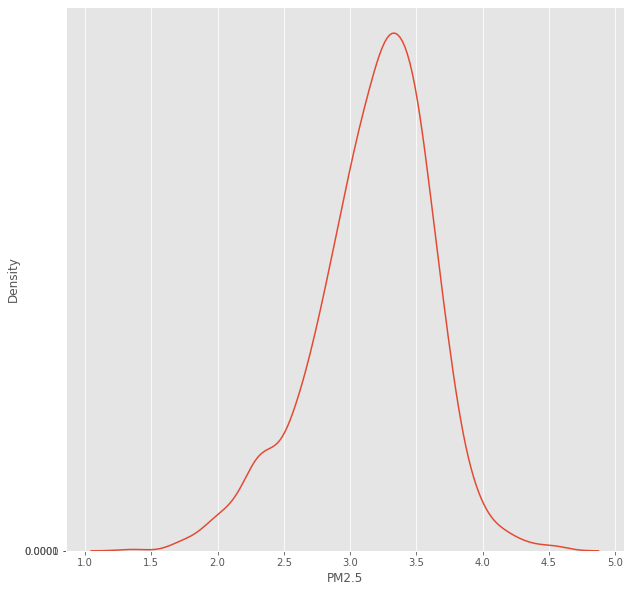

In [ ]:
#Densidad de PM2.5
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(28, 1)

print("Densidad de datos horarios de PM2.5")
sns.kdeplot(data=df_d, x="PM2.5",gridsize=200)
plt.yticks([0, 0.0001])
ax.set_xlabel('')
ax.set_title('Densidad de logaritmo de PM2.5')
    
plt.show()

In [ ]:
#Creación de la estructura del modelo incluyendo los regresores sin faltantes
#tomar en cuenta que el relleno de faltantes en los regresores deben mantener el mismo rango de los datos originales
#y se mantienen los valores originales de los regresores y sólo se agregan los rellenos en los faltantes
#Define el periodo de aprendizaje y el de prueba (cuatro años-un año)
pronostico="31/01/2021" #equivale a periods=762 
for p in param:
  df_modelo=df_d.reset_index()[['date2',p]].rename({'date2':'ds',p:'y'}, axis='columns') #estructura 'ds','y'
  train=df_modelo[(df_modelo['ds'] >= '2015-01-01') & (df_modelo['ds'] <= '2018-12-31')]
  test=df_modelo[(df_modelo['ds'] > '2018-12-31') ]
  m=Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=False)
  m.add_country_holidays(country_name='MX')
  m.fit(train)
  future=m.make_future_dataframe(periods=762) #Hasta el primer mes de 2021 (2021/01/31)
  forecast=m.predict(future)
 
  if p=='PM2.5':
    forecast['y']=df_modelo['y'] #emplea la variable original de PM2.5 (con faltantes) OJO traen diferente tamaño
    DF = pd.DataFrame(forecast[['ds','y']])
  else:
    yforc = pd.DataFrame(forecast[['ds','yhat']])
    yforc[p]=df_modelo['y']
    yforc['relleno']=yforc[p]                                                   #conserva originales
    yforc.loc[yforc[p].isnull(),'relleno']=yforc.loc[yforc[p].isnull(),'yhat']  #reemplaza faltantes con el pronóstico
    yforc.loc[yforc['relleno']<yforc[p].min(),'relleno']=yforc[p].min()         #corrige limite inferior del pronóstico
    yforc.loc[yforc['relleno']>yforc[p].max(),'relleno']=yforc[p].max()         #corrige limite superior del pronóstico
    #limites=yforc.describe()
    # for estad in limites.index[1:]:                                           #corrobora que los datos se mantengan en los rangos originales
    #   if limites.loc[estad,p]<limites.loc[estad,'relleno']:
    #     print("Revisa el relleno de {}, cambios en {}".format(p,estad))
    #     print("describe: ",limites.loc[estad,:])

    yforc.drop(columns=[p,'yhat'],inplace=True)
    yforc=yforc.rename(columns={'relleno': p})        

    DF=pd.merge(DF, yforc, 'inner', on='ds', indicator='union') 
    DF.drop(columns=['union'],inplace=True,axis=1)

#Construye la matriz de regresores sin faltantes
DF0_o=DF.copy()
DF0_o.drop(columns=['y'],inplace=True,axis=1)

print("Estructura de la base con 'y'")
print(DF.tail(3))
print("")
print("Estructura de la base de los regresores")
print(DF0_o.tail(3))


Estructura de la base con 'y'
             ds   y        CO  ...       SO2        TMP       WSP
2220 2021-01-29 NaN  0.830184  ...  7.856310  13.938985  1.553712
2221 2021-01-30 NaN  0.711280  ...  7.940347  14.030927  1.518796
2222 2021-01-31 NaN  0.648234  ...  8.501415  14.166236  1.447761

[3 rows x 14 columns]

Estructura de la base de los regresores
             ds        CO         NO  ...       SO2        TMP       WSP
2220 2021-01-29  0.830184  36.064682  ...  7.856310  13.938985  1.553712
2221 2021-01-30  0.711280  31.417609  ...  7.940347  14.030927  1.518796
2222 2021-01-31  0.648234  23.733323  ...  8.501415  14.166236  1.447761

[3 rows x 13 columns]


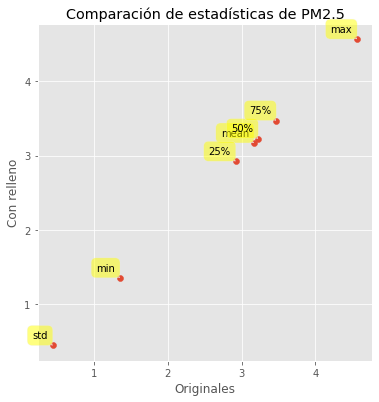

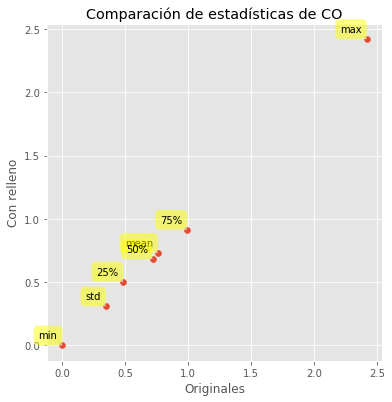

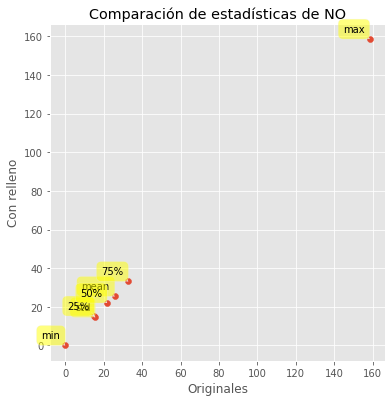

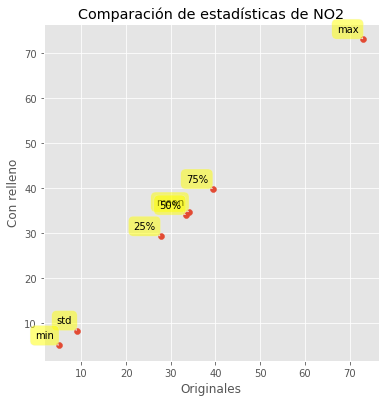

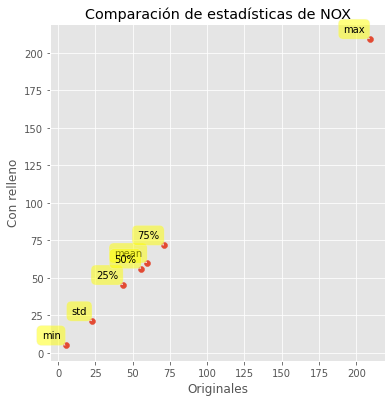

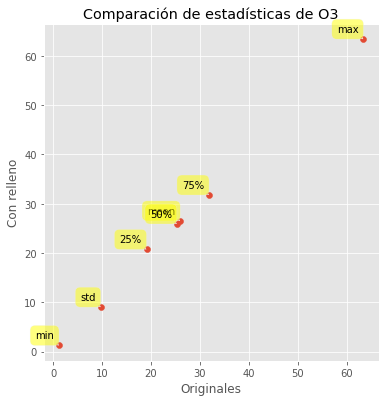

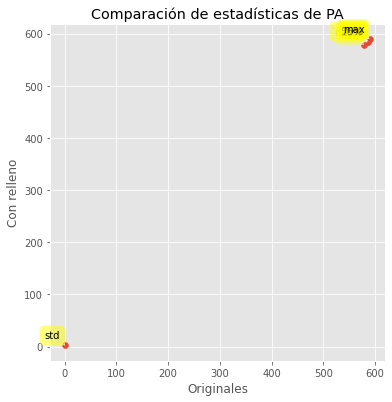

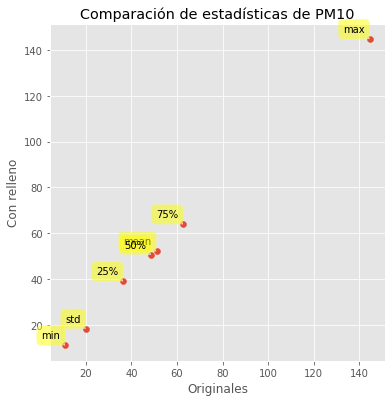

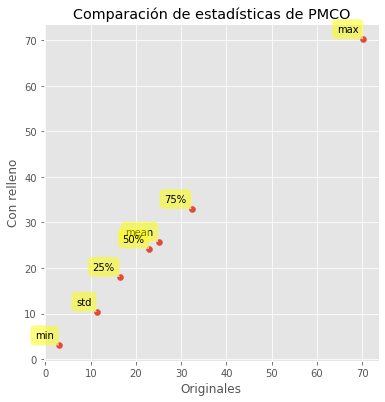

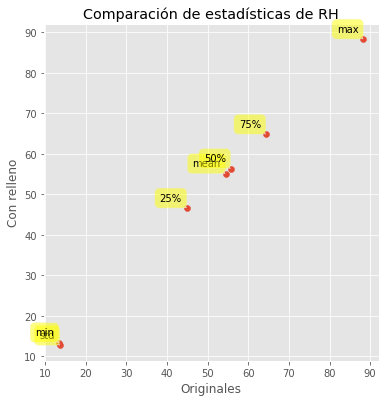

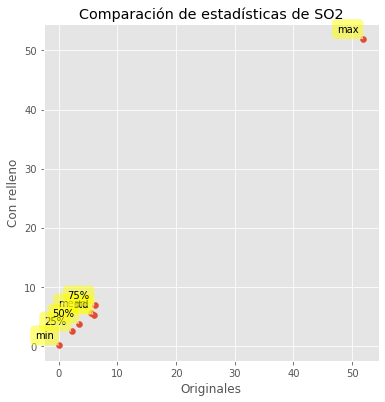

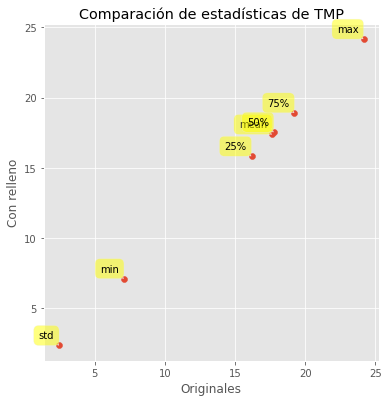

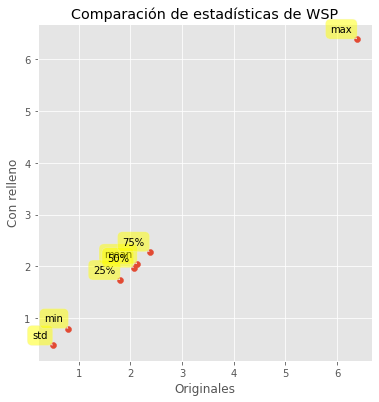

In [ ]:
#verifica rango de datos originales y con relleno
orig=df_d.describe()
rell=DF.describe()

labels = orig.index[1:]

#grafica PM25
plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(x=orig['PM2.5'][1:], y=rell['y'][1:], marker='o',
       cmap=plt.get_cmap('Spectral'))
for label, x, y in zip(labels, orig['PM2.5'][1:], rell['y'][1:]):
  plt.annotate(label,xy=(x, y),xytext=(-5, 5),
  textcoords='offset points', ha='right', va='bottom',
  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
  arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.xlabel('Originales')
plt.ylabel('Con relleno')
plt.title('Comparación de estadísticas de PM2.5')
plt.show()

#grafica los regresores
for p in orig.columns[1:]:
  plt.subplots(figsize=(6,6))
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(x=orig[p][1:], y=rell[p][1:], marker='o',
        cmap=plt.get_cmap('Spectral'))
  for label, x, y in zip(labels, orig[p][1:], rell[p][1:]):
    plt.annotate(label,xy=(x, y),xytext=(-5, 5),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.xlabel('Originales')
  plt.ylabel('Con relleno')
  plt.title('Comparación de estadísticas de '+p)
  plt.show()

del orig
del rell

Comparación entre los datos originales y los datos con relleno


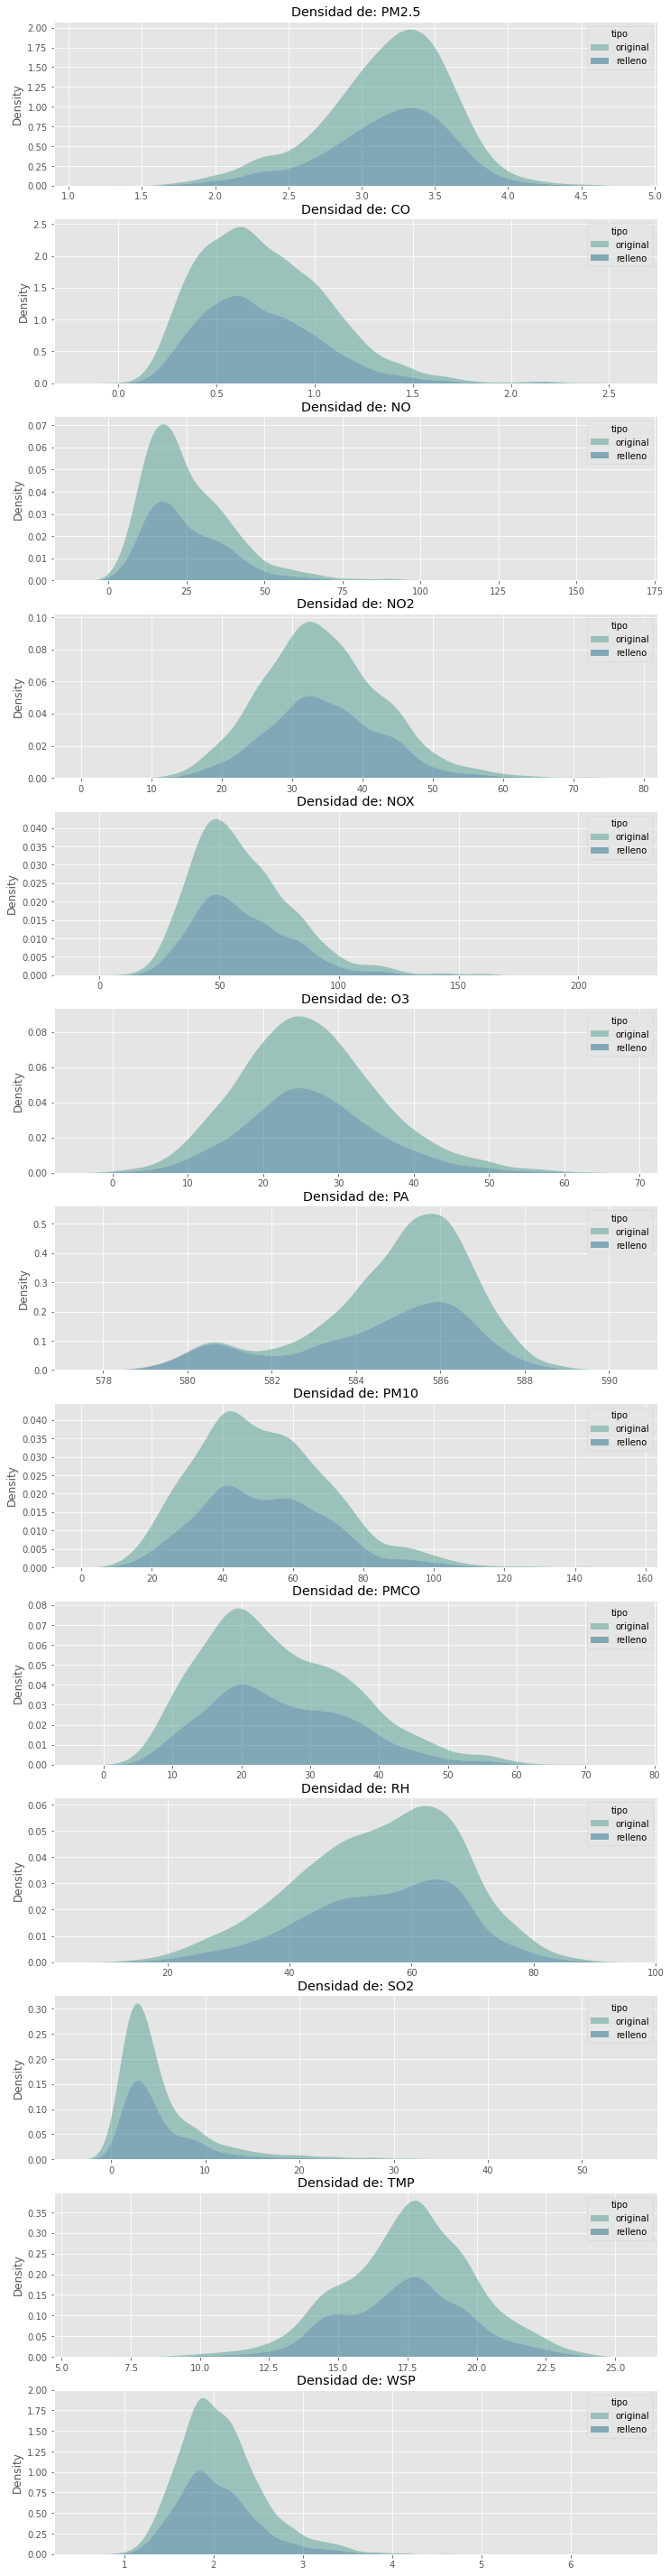

In [ ]:
#Un vistazo por los promedios diarios sin faltantes
#las escalas de los datos son muy variadas, por lo que se recomienda escalar
orig=df_d.copy()
orig=orig.reset_index()
rell=DF.copy()
orig.drop(columns=['date2'],inplace=True,axis=1)
rell.drop(columns=['ds'],inplace=True,axis=1)
rell.columns=orig.columns
orig['tipo']='original'
rell['tipo']='relleno'
ambos=pd.concat([orig,rell])
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)

print("Comparación entre los datos originales y los datos con relleno")
for i, cn in enumerate(ambos):
    if cn!='tipo':
      ax = plt.subplot(gs[i])    
      kdeplot(data=ambos, x=cn, hue="tipo", multiple="stack",fill=True,
              common_norm=False, palette="crest",alpha=.5,linewidth=0)
      ax.set_xlabel('')
      ax.set_title('Densidad de: ' + str(cn))
    
plt.show()

del orig
del rell
del ambos

#https://seaborn.pydata.org/generated/seaborn.kdeplot.html
#https://towardsdatascience.com/data-pre-processing-techniques-you-should-know-8954662716d6

In [ ]:
#Verifica el total de faltantes para usar el modelo
pd.DataFrame(pd.concat([DF.isnull().sum(),DF0_o.isnull().sum()],axis=1))

0    1
ds      0  0.0
y     712  NaN
CO      0  0.0
NO      0  0.0
NO2     0  0.0
NOX     0  0.0
O3      0  0.0
PA      0  0.0
PM10    0  0.0
PMCO    0  0.0
RH      0  0.0
SO2     0  0.0
TMP     0  0.0
WSP     0  0.0

In [ ]:
#Otro vistazo por los promedios diarios sin faltantes
#las escalas de los datos son muy variadas, por lo que se recomienda escalar
# DF_rev=DF.copy()
# DF_rev.drop(columns=['ds'],inplace=True,axis=1)

# plt.figure(figsize=(12,28*4))
# gs = gridspec.GridSpec(28, 1)
# for i, cn in enumerate(DF_rev):
#     ax = plt.subplot(gs[i])
#     sns.distplot(DF_rev[cn], bins=50)
#     ax.set_xlabel('')
#     ax.set_title('histogram of feature: ' + str(cn))
# plt.show()

# del DF_rev


In [ ]:
help(Prophet.add_regressor)

Help on function add_regressor in module fbprophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: op

In [ ]:
#Define el periodo de aprendizaje y el de prueba (4años-1año) para los datos con los regresores
train_o=DF[(DF['ds'] >= '2015-01-01') & (DF['ds'] <= '2018-12-31')]
test_o=DF[(DF['ds'] > '2018-12-31') & (DF['ds'] <= '2020-09-30')]
print("Total de datos en el conjunto de entrenamiento: ",train_o.shape[0])
print("Total de datos en el conjunto de prueba: ",test_o.shape[0])
print("Porcentaje de datos en el conjunto de entrenamiento: ",round(100*train_o.shape[0]/DF[DF['ds'] <= '2020-09-30'].shape[0],0))
print("Porcentaje de datos en el conjunto de prueba: ",round(100*test_o.shape[0]/DF[DF['ds'] <= '2020-09-30'].shape[0],0))
print("Regresores en el conjunto de entrenamiento:")
print(train_o.count())
print("Regresores en el conjunto de prueba:")
print(test_o.count())

Total de datos en el conjunto de entrenamiento:  1461
Total de datos en el conjunto de prueba:  639
Porcentaje de datos en el conjunto de entrenamiento:  70.0
Porcentaje de datos en el conjunto de prueba:  30.0
Regresores en el conjunto de entrenamiento:
ds      1461
y       1245
CO      1461
NO      1461
NO2     1461
NOX     1461
O3      1461
PA      1461
PM10    1461
PMCO    1461
RH      1461
SO2     1461
TMP     1461
WSP     1461
dtype: int64
Regresores en el conjunto de prueba:
ds      639
y       266
CO      639
NO      639
NO2     639
NOX     639
O3      639
PA      639
PM10    639
PMCO    639
RH      639
SO2     639
TMP     639
WSP     639
dtype: int64


In [ ]:
#Relación de renglones por tipo de archivo train/test/future
print("Filas en df_d + fechas de pronostico",df_d.shape[0]+489)
print("Filas en DF",DF.shape[0])
print("Filas en train y test",train_o.shape[0]+test_o.shape[0])
print("Filas en future",DF.shape[0]-(train_o.shape[0]+test_o.shape[0]))
print("")
ds_train=train_o.ds
ds_resto=DF.ds[~DF.ds.isin(train_o.ds)]
ds_test=ds_resto[ds_resto.isin(test_o.ds)]
ds_future=ds_resto[~ds_resto.isin(test_o.ds)]
print("Rango de fechas del conjunto de entrenamiento:")
print([ds_train.min(),ds_train.max()])
print("Rango de fechas del conjunto de prueba:")
print([ds_test.min(),ds_test.max()])
print("Rango de fechas del conjunto de pronóstico:")
print([ds_future.min(),ds_future.max()])
print("")
print("Fechas finales:")
print("Entrenamiento")
print(ds_train.tail()) #del 2015/01/01 al 2019/07/31 son 1673 filas
print("Prueba")
print(ds_test.tail()) #del 2019/08/01  al 2020/09/30 son 427 filas
print("Pronóstico")
print(ds_future.tail()) #del 2020/10/01  al 2021/01/31 son 123 filas

Filas en df_d + fechas de pronostico 2223
Filas en DF 2223
Filas en train y test 2100
Filas en future 123

Rango de fechas del conjunto de entrenamiento:
[Timestamp('2015-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')]
Rango de fechas del conjunto de prueba:
[Timestamp('2019-01-01 00:00:00'), Timestamp('2020-09-30 00:00:00')]
Rango de fechas del conjunto de pronóstico:
[Timestamp('2020-10-01 00:00:00'), Timestamp('2021-01-31 00:00:00')]

Fechas finales:
Entrenamiento
1456   2018-12-27
1457   2018-12-28
1458   2018-12-29
1459   2018-12-30
1460   2018-12-31
Name: ds, dtype: datetime64[ns]
Prueba
2095   2020-09-26
2096   2020-09-27
2097   2020-09-28
2098   2020-09-29
2099   2020-09-30
Name: ds, dtype: datetime64[ns]
Pronóstico
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, dtype: datetime64[ns]


El proceso de normalizar los datos se hará para cada conjunto de datos por separado (train,test)

Comparación entre los datos estandarizados (boxplot)


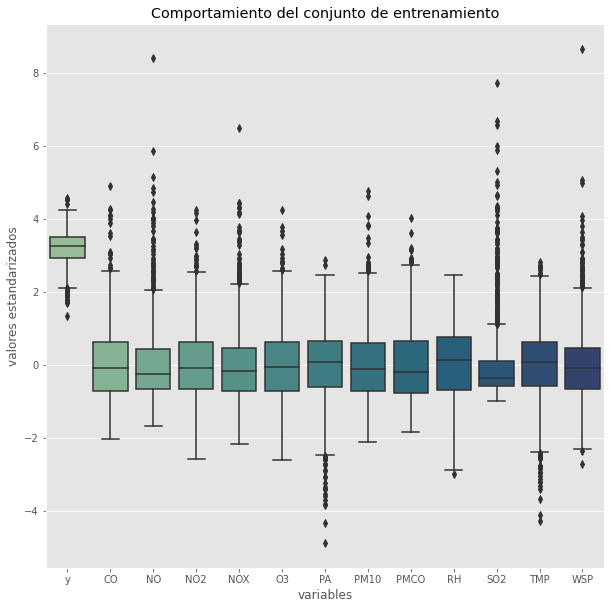

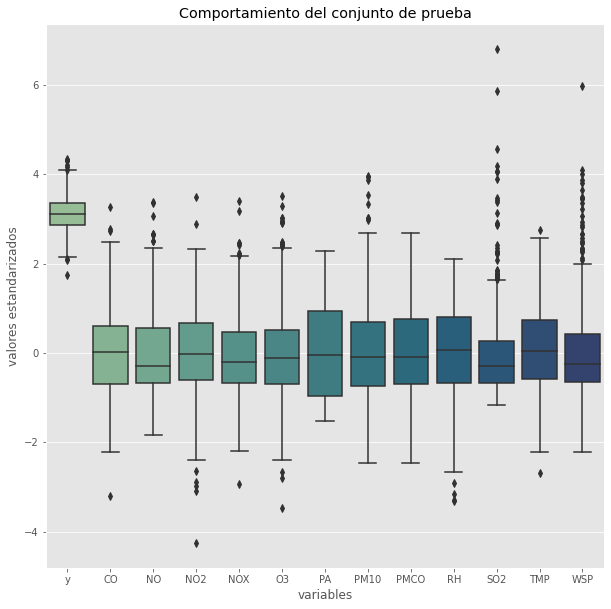

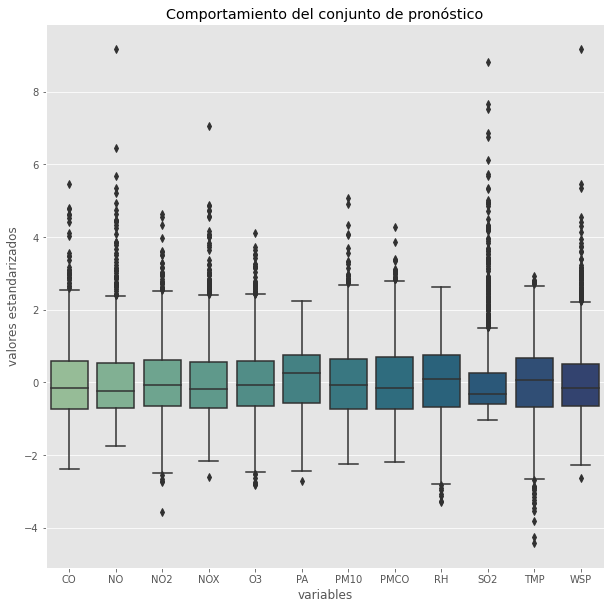

In [ ]:
#El proceso de normalizar los datos se hará para cada conjunto de datos por separado (train,test,future) sin modificar y

train=train_o.copy()
test=test_o.copy()
DF0=DF0_o.copy()


class MyScaler(TransformerMixin, BaseEstimator):            #función para estandarizar #https://stackoverflow.com/questions/59434397/standardscaler-valueerror-operands-could-not-be-broadcast-together-with-shapes
    def fit(self, X, y=None):
        self.means_ = X.mean(axis=0)
        self.std_dev_ = X.std(axis=0)
        return self
    def transform(self, X, y=None):
        return (X - self.means_[:X.shape[1]]) / self.std_dev_[:X.shape[1]]

scaler = MyScaler()

#estandarización
train.iloc[:,2:]=scaler.fit_transform(train.iloc[:,2:])           #no se transforma 'ds' ni 'y'
test.iloc[:,2:]=scaler.fit_transform(test.iloc[:,2:])             #no se transforma 'ds' ni 'y'
DF0.iloc[:,1:]=scaler.fit_transform(DF0.iloc[:,1:])               #no se transforma 'ds'


train_bp=pd.melt(train, id_vars=['ds'], value_vars=train.columns[~train.columns.isin(['ds'])])
test_bp=pd.melt(test, id_vars=['ds'], value_vars=test.columns[~test.columns.isin(['ds'])])
DF0_bp=pd.melt(DF0, id_vars=['ds'], value_vars=DF0.columns[~DF0.columns.isin(['ds'])])

print("Comparación entre los datos estandarizados (boxplot)")
plt.figure(figsize=(10,10))
ax=sns.boxplot(x='variable',y='value', data=train_bp, palette="crest")
ax.set(xlabel="variables", ylabel="valores estandarizados", title='Comportamiento del conjunto de entrenamiento')
plt.show()

plt.figure(figsize=(10,10))
ax=sns.boxplot(x='variable',y='value', data=test_bp, palette="crest")
ax.set(xlabel="variables", ylabel="valores estandarizados", title='Comportamiento del conjunto de prueba')
plt.show()


plt.figure(figsize=(10,10))
ax=sns.boxplot(x='variable',y='value', data=DF0_bp, palette="crest")
ax.set(xlabel="variables", ylabel="valores estandarizados", title='Comportamiento del conjunto de pronóstico')
plt.show()

del train_bp
del test_bp
del DF0_bp
#https://stackoverflow.com/questions/59434397/standardscaler-valueerror-operands-could-not-be-broadcast-together-with-shapes
#https://medium.com/datadriveninvestor/data-preprocessing-for-machine-learning-188e9eef1d2c


Pronóstico de log(PM2.5) al 31/01/2021 univariado


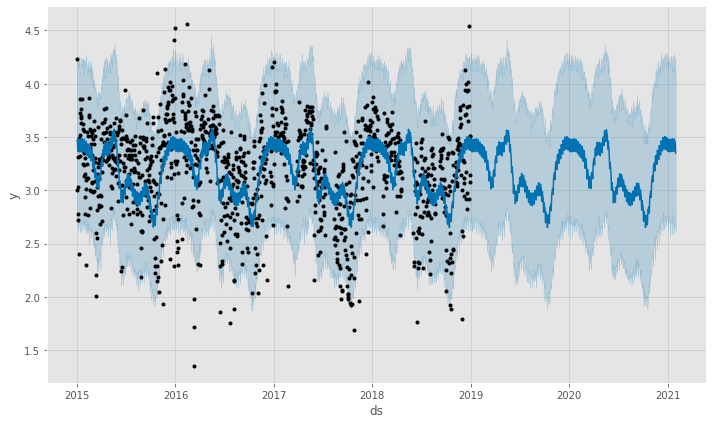

In [ ]:
#Modelo PM2.5 univariado
m_unv=Prophet(interval_width=0.95,yearly_seasonality=True,
              weekly_seasonality=True,daily_seasonality=False,growth='flat') #define la estructura del modelo

m_unv.fit(train[['ds','y']])                              #ajusta el modelo
forecast_unv=m_unv.predict(DF0[['ds']])                     #predicción
print("Pronóstico de log(PM2.5) al "+ pronostico +" univariado")
fig0 = m_unv.plot(forecast_unv)


In [ ]:
#estimador e intervalo de confianza para el modelo univariado
np.exp(forecast_unv[['yhat','yhat_lower','yhat_upper']]).head(3)

yhat  yhat_lower  yhat_upper
0  32.058065   15.102702   65.256133
1  32.012442   15.240420   68.591156
2  30.279978   14.072318   66.184338

Pronóstico de log(PM2.5) al 31/01/2021 con días festivos


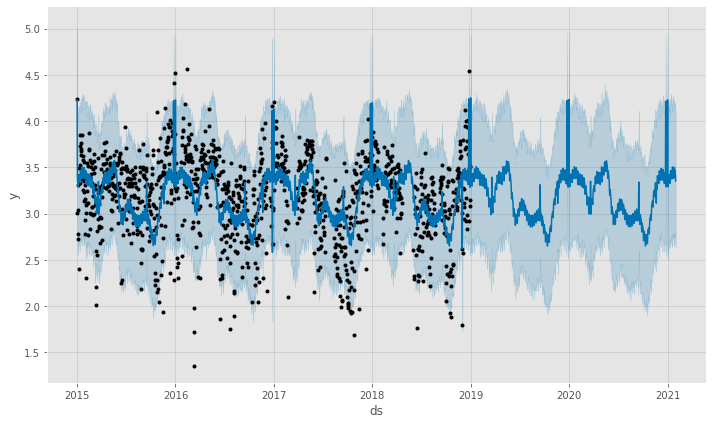

In [ ]:
#Modelo PM2.5 univariado y días festivos
m_fes=Prophet(interval_width=0.95,yearly_seasonality=True,
              weekly_seasonality=True,daily_seasonality=False,growth='flat') #define la estructura del modelo
  
m_fes.add_country_holidays(country_name='MX')             #agrega los días festivos
m_fes.fit(train[['ds','y']])                              #ajusta el modelo
forecast_fes=m_fes.predict(DF0[['ds']])                     #predicción

print("Pronóstico de log(PM2.5) al "+ pronostico +" con días festivos")
fig0 = m_fes.plot(forecast_fes)


In [ ]:
#estimador e intervalo de confianza para el modelo con días festivos
np.exp(forecast_fes[['yhat','yhat_lower','yhat_upper']].head(3))

yhat  yhat_lower  yhat_upper
0  68.771411   32.739053  148.632097
1  29.526874   13.858931   64.577441
2  28.257643   13.341737   60.927745

Pronóstico de PM2.5 al 31/01/2021 con regresores y días festivos


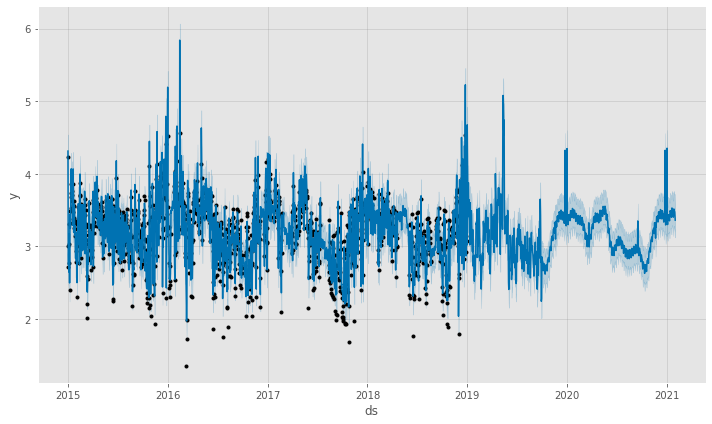

In [ ]:
#Modelo PM2.5 vs días festivos y regresores
m_reg=Prophet(interval_width=0.95,yearly_seasonality=True,
              weekly_seasonality=True,daily_seasonality=False,growth='flat') #define la estructura del modelo
for p in param[1:]:
  m_reg.add_regressor(p,standardize=False)   #agrega los regresores
  
m_reg.add_country_holidays(country_name='MX') #agrega los días festivos
m_reg.fit(train)                              #ajusta el modelo
forecast_reg=m_reg.predict(DF0)               #predicción

print("Pronóstico de PM2.5 al "+ pronostico +" con regresores y días festivos")
fig1 = m_reg.plot(forecast_reg)

#https://futurice.com/blog/business-forecasting-with-facebook-prophet

In [ ]:
#estimador e intervalo de confianza para el modelo con días festivos y regresores
np.exp(forecast_reg[['yhat','yhat_lower','yhat_upper']].head(3))

yhat  yhat_lower  yhat_upper
0  74.593500   59.495748   93.813707
1  17.904215   14.357943   22.700648
2  15.529882   11.804252   19.330276

In [ ]:
#Un vistazo a la descomposición de la serie OPCION 1
#fig = m_reg.plot_components(forecast_reg)

In [ ]:
#Un vistazo a la descomposición de la serie OPCION 2

plot_components_plotly(m_reg, forecast_reg)

Pronóstico de log(PM2.5) al 31/01/2021 con regresores, días festivos y puntos de cambio


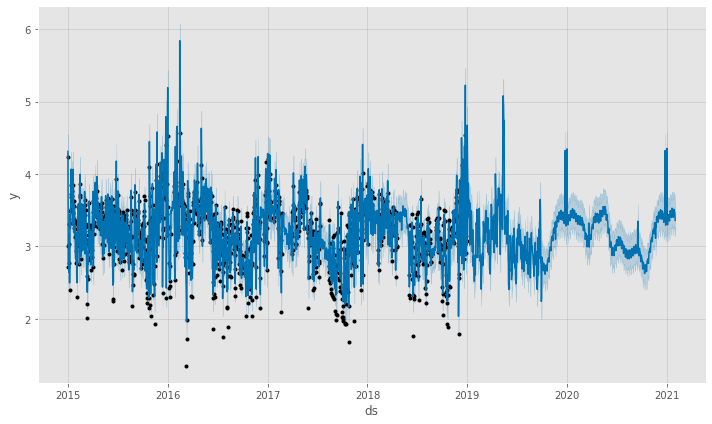

In [ ]:
#Modelo PM2.5 vs regresores y puntos de cambio (changepoint)
#no representa un plus pues la tendencia es casi cero
m_reg_chp=Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True,
                  daily_seasonality=False,growth='flat',changepoint_prior_scale=0.001) #define la estructura del modelo
for p in param[1:]:
  m_reg_chp.add_regressor(p,standardize=False)    #agrega los regresores

m_reg_chp.add_country_holidays(country_name='MX')  #agrega los días festivos
m_reg_chp.fit(train)                               #ajusta el modelo
forecast_reg_chp=m_reg_chp.predict(DF0)          #predicción

print("Pronóstico de log(PM2.5) al "+ pronostico +" con regresores, días festivos y puntos de cambio")
fig2 = m_reg_chp.plot(forecast_reg_chp)

In [ ]:
#Un vistazo a la descomposición de la serie

plot_components_plotly(m_reg_chp, forecast_reg_chp)

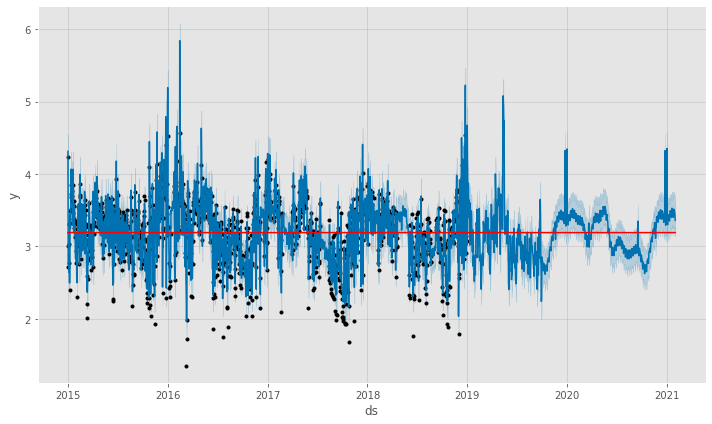

In [ ]:
#Un viztazo a los changepoints
#No muestran impacto en la serie

fig = m_reg.plot(forecast_reg_chp)
a = add_changepoints_to_plot(fig.gca(), m_reg_chp, forecast_reg_chp)

In [ ]:
#Guardar los modelos con regresores y con puntos de cambio


with open('m_reg_'+estac+'.json', 'w') as fout:
    json.dump(model_to_json(m_reg), fout)  # Save model

with open('m_reg_chp_'+estac+'.json', 'w') as fout:
    json.dump(model_to_json(m_reg_chp), fout)  # Save model


#with open('m_reg_MER.json', 'r') as fin:
#    m_reg_MER = model_from_json(json.load(fin))  # Load model

#with open('m_reg_chp_MER.json', 'r') as fin:
#    m_reg_chp_MER = model_from_json(json.load(fin))  # Load model

In [ ]:
#Un vistazo al periodo para evaluar la validación cruzada

df_cv = cross_validation(m_reg, initial='1200 days', period='100 days', horizon = '100 days')
print(df_cv.head())

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-14 00:00:00 and 2018-09-22 00:00:00



          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2018-06-15  3.138412    2.906790    3.372555  3.269252 2018-06-14
1 2018-06-16  2.798554    2.558932    3.058049  2.847812 2018-06-14
2 2018-06-17  2.333437    2.086814    2.565721  1.766442 2018-06-14
3 2018-06-18  2.533491    2.305186    2.767431  2.330756 2018-06-14
4 2018-06-19  2.636598    2.406150    2.864512  2.617825 2018-06-14


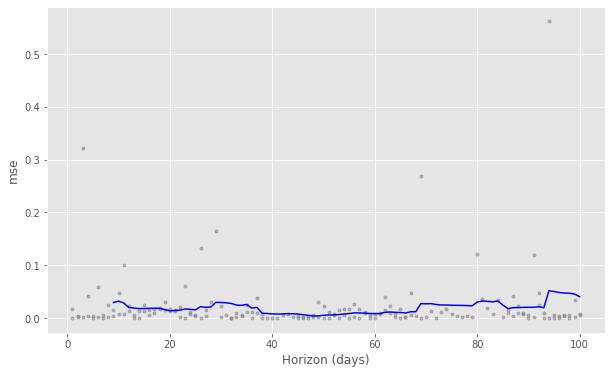

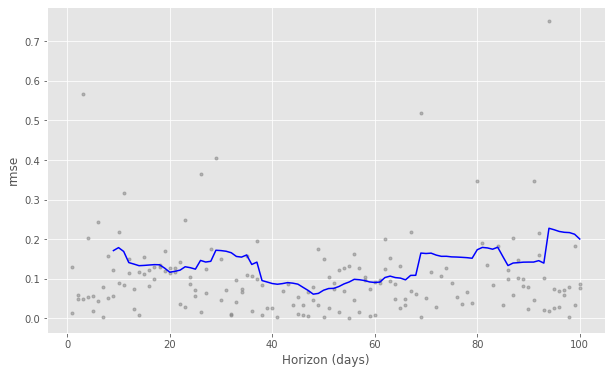

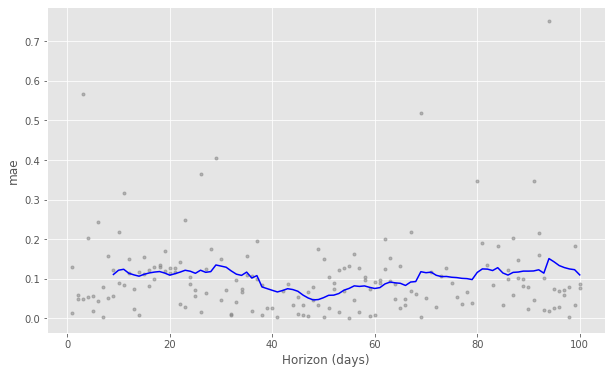

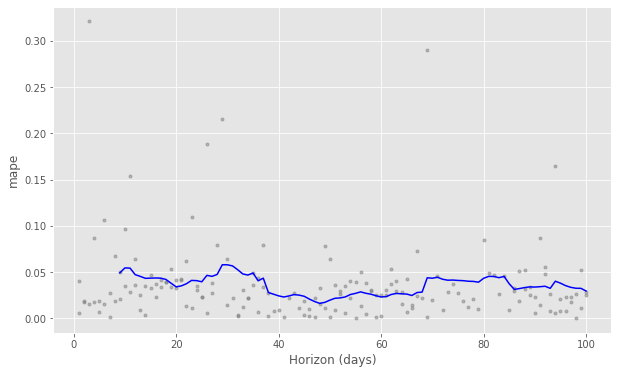

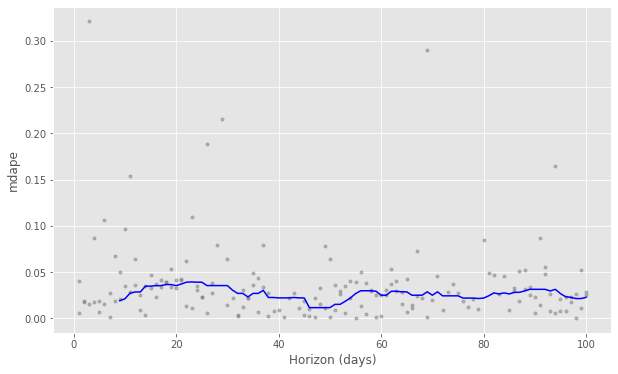

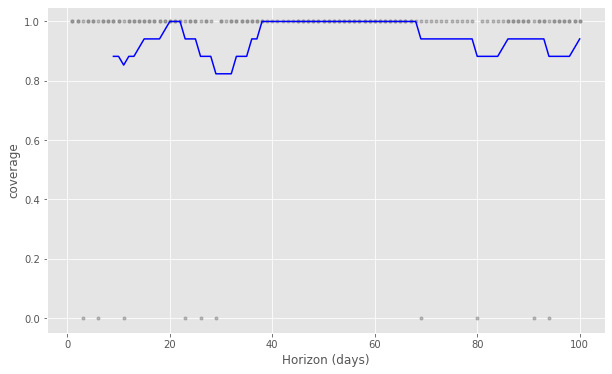

In [ ]:
#Evaluar las métricas

df_m = performance_metrics(df_cv)
df_m.head()
#un vistazo a las métricas

for m in df_m.columns[1:]:
  plot_cross_validation_metric(df_cv, metric=m)


In [ ]:
help(fbprophet.diagnostics)

Help on module fbprophet.diagnostics in fbprophet:

NAME
    fbprophet.diagnostics

DESCRIPTION
    # -*- coding: utf-8 -*-
    # Copyright (c) Facebook, Inc. and its affiliates.

FUNCTIONS
    coverage(df, w)
        Coverage
        
        Parameters
        ----------
        df: Cross-validation results dataframe.
        w: Aggregation window size.
        
        Returns
        -------
        Dataframe with columns horizon and coverage.
    
    cross_validation(model, horizon, period=None, initial=None, parallel=None, cutoffs=None)
        Cross-Validation for time series.
        
        Computes forecasts from historical cutoff points, which user can input.
        If not provided, begins from (end - horizon) and works backwards, making
        cutoffs with a spacing of period until initial is reached.
        
        When period is equal to the time interval of the data, this is the
        technique described in https://robjhyndman.com/hyndsight/tscv/ .
        
     

In [ ]:
#Buscar los mejores Hiperparametros del modelo
#Validación cruzada

from datetime import datetime
# datetime object containing current date and time
before = datetime.now()

#definición de la malla de los hiperparametros
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'interval_width':[0.95], 
    'changepoint_range' : [0.9],
    'yearly_seasonality':[True], 
    
}

# Generación de todas las combinaciones de hiperparámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmses = []  #Lista para guardar RMSE para cada combinación de hiperparámetros

# Evaluación de los hiperparámetros por medio de validación cruzada
for params in all_params: 
    m_cv = Prophet(**params)                      #agrega los hiperparámetros
    m_cv.add_country_holidays(country_name='MX')  #agrega los días festivos
    for p in param[1:]:
      m_cv.add_regressor(p,standardize=False)    #agrega los regresores

    m_cv.fit(train)                               #ajusta el modelo
    df_cv = cross_validation(m_cv,initial='1200 days',
                             period='100 days',horizon='100 days',
                             parallel="processes") #realiza la validación cruzada
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Select best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)
now = datetime.now()
print(now-before)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-14 00:00:00 and 2018-09-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8ad632ca58>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-14 00:00:00 and 2018-09-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8ad669e5f8>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-14 00:00:00 and 2018-09-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8ad2952780>
INFO:fbprophet:Disabling daily seasonality. Run prop

    changepoint_prior_scale  ...      rmse
0                     0.001  ...  0.149875
1                     0.001  ...  0.147777
2                     0.001  ...  0.147885
3                     0.001  ...  0.148284
4                     0.001  ...  0.149917
..                      ...  ...       ...
59                    0.500  ...  0.158207
60                    0.500  ...  0.185501
61                    0.500  ...  0.161511
62                    0.500  ...  0.157904
63                    0.500  ...  0.158269

[64 rows x 7 columns]
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'interval_width': 0.95, 'changepoint_range': 0.9, 'yearly_seasonality': True}
0:08:16.435565


In [ ]:
best_params

{'changepoint_prior_scale': 0.01,
 'changepoint_range': 0.9,
 'holidays_prior_scale': 10.0,
 'interval_width': 0.95,
 'seasonality_prior_scale': 1.0,
 'yearly_seasonality': True}

In [ ]:
bp=list(best_params.values())
bp
#['changepoint_prior_scale','seasonality_prior_scale','holidays_prior_scale',
#'interval_width','changepoint_range','yearly_seasonality']

[0.01, 1.0, 10.0, 0.95, 0.9, True]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


0:05:07.551129


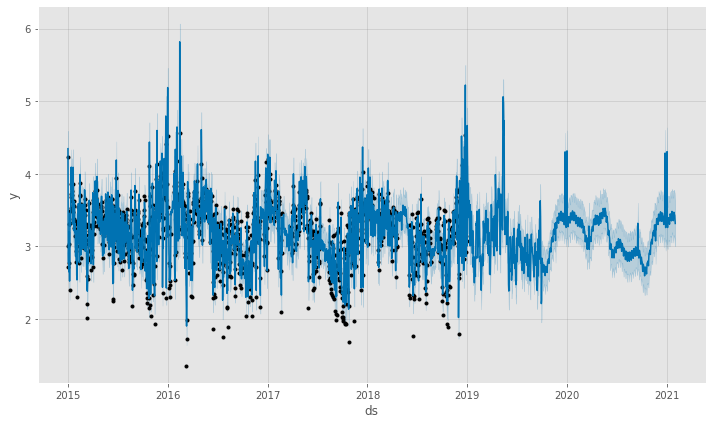

In [ ]:
before=datetime.now()

m_bp = Prophet(mcmc_samples=300, 
          changepoint_prior_scale=bp[0],seasonality_prior_scale=bp[1],holidays_prior_scale=bp[2],interval_width=bp[3],changepoint_range=bp[4], 
          yearly_seasonality=bp[5],weekly_seasonality=True,daily_seasonality=False)

for p in param[1:]:
  m_bp.add_regressor(p,standardize=True)     #agrega regresores

m_bp.add_country_holidays(country_name='MX') #agrega días festivos
forecast_bp = m_bp.fit(train).predict(DF0)   #ajusta el modelo
fig3 = m_bp.plot(forecast_bp)

now = datetime.now()
print(now-before)
#otra manera de ver la misma gráfica
#pd.concat([DF.set_index('ds')['y'],forecast_bp.set_index('ds')['yhat']],axis=1).plot(figsize=(16,8))

In [ ]:
#Guarda el modelo
with open('m_bp_'+estac+'.json', 'w') as fout:
    json.dump(model_to_json(m_bp), fout)  # Save model


#with open('m_bp_MER.json', 'r') as fin:
#    m_bp = model_from_json(json.load(fin))  # Load model


In [ ]:
#Un vistazo a la descomposición de la serie
plot_components_plotly(m_bp, forecast_bp)

In [ ]:
#Validación cruzada con el mejor modelo
#Un vistazo al periodo para evaluar la validación cruzada
before=datetime.now()
df_cv_bp = cross_validation(m_bp, initial='1200 days', period='100 days', horizon = '100 days')
print(df_cv_bp.head())
now=datetime.now()
print(now-before)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-14 00:00:00 and 2018-09-22 00:00:00


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)



          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2018-06-15  3.145529    2.916011    3.386168  3.269252 2018-06-14
1 2018-06-16  2.817356    2.582385    3.065903  2.847812 2018-06-14
2 2018-06-17  2.357905    2.126178    2.603847  1.766442 2018-06-14
3 2018-06-18  2.555493    2.316482    2.785121  2.330756 2018-06-14
4 2018-06-19  2.660743    2.410340    2.912017  2.617825 2018-06-14
0:11:05.622039


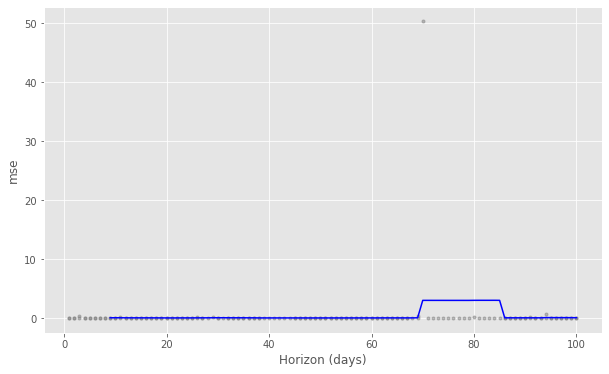

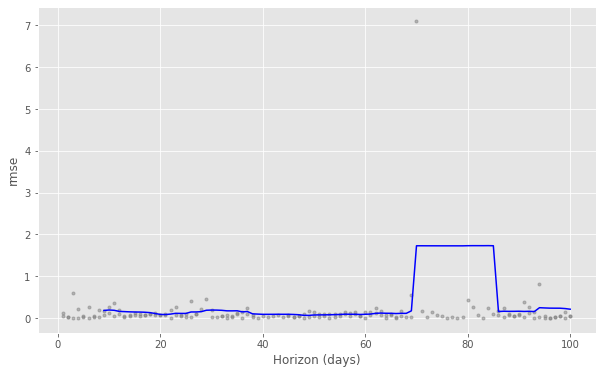

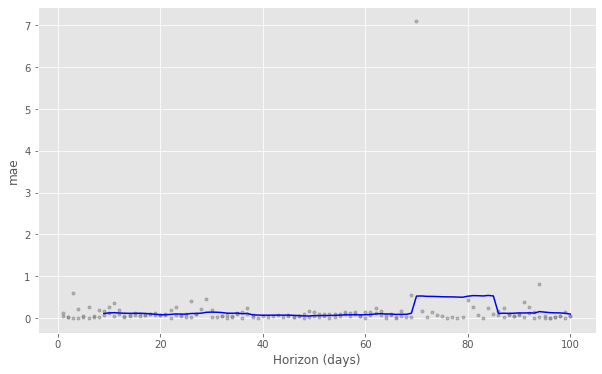

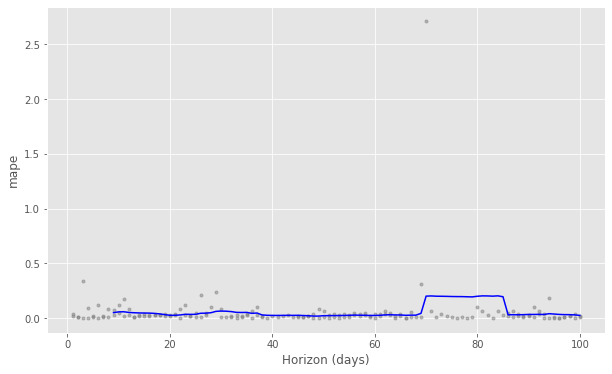

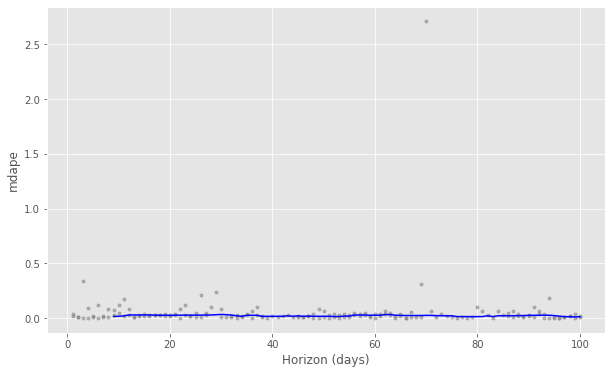

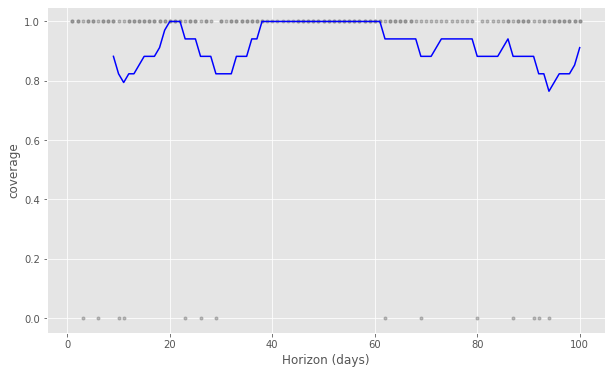

In [ ]:
#Evaluar las métricas del mejor modelo

df_m_bp = performance_metrics(df_cv_bp)
df_m_bp.head()
#un vistazo a las métricas

for m in df_m_bp.columns[1:]:
  plot_cross_validation_metric(df_cv_bp, metric=m)

In [ ]:
forecast_bp

ds     trend  ...  multiplicative_terms_upper      yhat
0    2015-01-01  3.245688  ...                         0.0  4.345874
1    2015-01-02  3.245573  ...                         0.0  2.899952
2    2015-01-03  3.245458  ...                         0.0  2.772248
3    2015-01-04  3.245343  ...                         0.0  2.956263
4    2015-01-05  3.245228  ...                         0.0  2.648027
...         ...       ...  ...                         ...       ...
2218 2021-01-27  3.143257  ...                         0.0  3.449182
2219 2021-01-28  3.143233  ...                         0.0  3.434052
2220 2021-01-29  3.143210  ...                         0.0  3.430836
2221 2021-01-30  3.143186  ...                         0.0  3.380604
2222 2021-01-31  3.143162  ...                         0.0  3.315130

[2223 rows x 103 columns]

In [ ]:
#Define funciones para visualizar entrenamiento, prueba y pronóstico juntos

def make_verif(forecast, data_train, data_test): 
    """
    put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting    
    """
    dat=pd.DataFrame(pd.to_datetime(forecast.ds, format="%Y-%m-%d"))
    dat=dat.set_index('ds')
    if type(forecast.index)!=type(dat.index):
      forecast.index = pd.to_datetime(forecast.ds, format="%Y-%m-%d")

    dat=pd.DataFrame(pd.to_datetime(train.ds, format="%Y-%m-%d"))
    dat=dat.set_index('ds')
    if type(train.index)!=type(dat.index):
      data_train.index = pd.to_datetime(data_train.ds, format="%Y-%m-%d")

    dat=pd.DataFrame(pd.to_datetime(test.ds, format="%Y-%m-%d"))
    dat=dat.set_index('ds')
    if type(test.index)!=type(dat.index):
      data_test.index = pd.to_datetime(data_test.ds, format="%Y-%m-%d")
      
    data = pd.concat([data_train, data_test], axis=0)                       #une verticalmente train test    
    forecast.loc[:,'y'] = data.loc[:,'y']                                    #agrega 'y' 
    
    return forecast

In [ ]:
def plot_verif(verif, year=2019):
    """
    plots the forecasts and observed data, the year parameters is used to indicate 
    the division between the training and test sets 
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]                                                         #train
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]                                                              #test
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f


log(PM2.5)


ConversionError: ignored

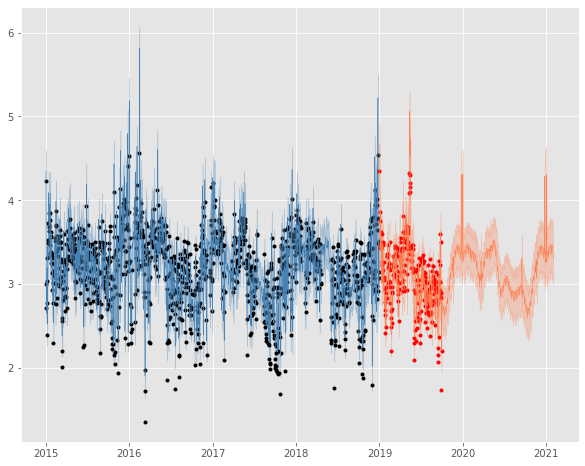

In [ ]:
verificador=make_verif(forecast_bp, train, test)
print("log(PM2.5)")
plot_verif(verificador, year=2019)


In [ ]:

verificador[['y','yhat','yhat_lower','yhat_upper']]=np.exp(verificador[['y','yhat','yhat_lower','yhat_upper']])
print("PM2.5")
plot_verif(verificador, year=2019)

ConversionError: ignored

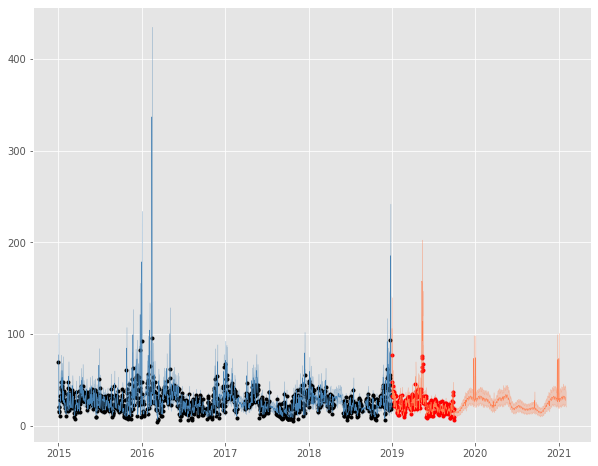

In [ ]:
# year=2019
# f, ax = plt.subplots(figsize=(10, 8))

# train = verif.loc[:str(year - 1),:]                                                         #train

# ax.plot(train.index, train.y, 'ko', markersize=3)

# ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)

# ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)

# test = verif.loc[str(year):,:]                                                              #test

# ax.plot(test.index, test.y, 'ro', markersize=3)

# ax.plot(test.index, test.yhat, color='coral', lw=0.5)

# ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)

# ax.axvline(str(year), color='0.8', alpha=0.7)

# ax.grid(ls=':', lw=0.5)


In [ ]:
#Intervalos de calidad del aire
#transformar y a np.exp(y)
# def plot_verif(verif, year=2019):
#     """
#     plots the forecasts and observed data, the year parameters is used to indicate 
#     the division between the training and test sets 
#     """
    
#     f, ax = plt.subplots(figsize=(10, 8))
    
#     train = verif.loc[:str(year - 1),:]                                                         #train
    
#     ax.plot(train.index, train.y, 'ko', markersize=3)
    
#     ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
#     ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
#     test = verif.loc[str(year):,:]                                                              #test
    
#     ax.plot(test.index, test.y, 'ro', markersize=3)
    
#     ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
#     ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
#     ax.axvline(str(year), color='0.8', alpha=0.7)
    
#     ax.grid(ls=':', lw=0.5)
    
#     return f


In [ ]:
# Evaluación de estacionariedad
# Se requiere que las series no tengan datos faltantes
# Considerando una base sin faltantes
# para lo cual se relleno previamente con los perfiles horarios




#carga la base con relleno de faltantes
df_all= pd.read_csv(ruta+'Sitios/' + estac +'_rell00.csv')
df_all.date2=pd.to_datetime(df['date2'],format="%Y-%m-%d %H:%M:%S")
df_all=df.set_index('date2')

#Correlación
df_corr=df_all[['Hour', 'Month', 'year', 'id_station', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PA', 'PM10', 'PM2.5', 'PMCO', 'RH', 'SO2',
       'TMP', 'WDR', 'WSP']].corr(method='spearman')

#listado de variables con correlación mayor o igual que 0.25
var_corr=df_corr[df_corr['PM2.5'].abs() >= 0.25]['PM2.5'].sort_values(ascending=False).index

#listado de variables con correlación menor que 0.25
var_no_corr=df_all.columns[~df_all.columns.isin(var_corr)][7:]


#Función para evaluar estacionalidad
#Null Hypothesis - Series possesses a unit root and hence is not stationary
#Alternate Hypothesis - Series is stationary

def adfuller_test(variable):
  result = adfuller(df[variable])
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critial Values: {result[4]}')
  print(variable)
  if result[1] > 0.05 :
    print('Series is not Stationary')
  else:
    print('Series is Stationary')
    print('')

#Función para evaluar causalidad entre X y Y
# H0: Xt does not granger causes Yt
# H1: Xt granger causes Yt  

def grangercausality_tests(df, variable1, variable2, max_lags):
  results=grangercausalitytests(df[[variable1,variable2]], max_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print('p values por lag entre {} y {}'.format(variable1,variable2))
  print(p_values)
  print('')



#Evaluar estacionalidad en variables con mayor correlación
for i in var_corr:
  adfuller_test(i)

#Evaluar causalidad en variables con mayor correlación
for j in var_corr[1:]:
  grangercausality_tests(df_all, 'PM2.5', j, 24)
for j in var_corr[1:]:
  grangercausality_tests(df_all, j , 'PM2.5', 24)


#Evaluar estacionalidad en variables con menor correlación
for i in var_no_corr:
  adfuller_test(i)

#Evaluar causalidad en variables con menor correlación  
for j in var_no_corr:
  grangercausality_tests(df_all, 'PM2.5', j, 24)
for j in var_no_corr:
  grangercausality_tests(df_all, j, 'PM2.5', 24)      